In [1]:
# ------ Imports ------
import pandas as pd
# Import the NeuralProphet class
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

## Energy Load

In [2]:
df = pd.read_csv("../data/load_15-24.csv")
# Rename the columns
df = df.rename(columns={'date': 'ds', 'load': 'y'})

# Convert 'ds' to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Keep only 'ds' and 'y' columns
df = df[['ds', 'y']]

In [3]:
# Split the dataframe in a train and test set

# Filter df for the years 2022 and 2023
df_train = df[(df['ds'].dt.year == 2022)]
df_test = df[(df['ds'].dt.year == 2023) | (df['ds'].dt.year == 2024)]

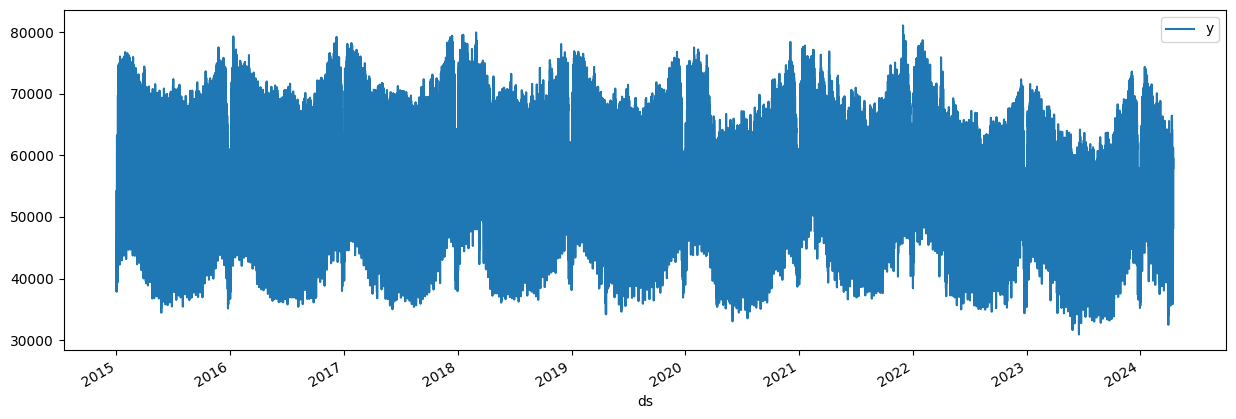

In [4]:
plt = df.plot(x="ds", y="y", figsize=(15, 5))

In [10]:
# Create a NeuralProphet model with default parameters
m = NeuralProphet()
# Use static plotly in notebooks
m.set_plotting_backend("plotly-resampler")

In [8]:
df_train[-24*14:]

,ds,y
69792,2022-12-18 00:00:00,49826.75
69793,2022-12-18 01:00:00,48147.75
69794,2022-12-18 02:00:00,46816.25
69795,2022-12-18 03:00:00,46227.25
69796,2022-12-18 04:00:00,46297.75
...,...,...
70123,2022-12-31 19:00:00,49969.25
70124,2022-12-31 20:00:00,46745.25
70125,2022-12-31 21:00:00,44272.50
70126,2022-12-31 22:00:00,42715.75


In [11]:
# Fit the model on the dataset (this might take a bit)
metrics = m.fit(df_train[-24*14:])

Finding best initial lr:   0%|          | 0/215 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [14]:
# Create a new dataframe reaching (NUMBER OF TEST) into the future for our forecast, n_historic_predictions also shows historic data
n = len(df_test)
df_future = m.make_future_dataframe(df_train[-24*14:], n_historic_predictions=True, periods=24)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)

Predicting: 21it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': 'a7e87625-e3a9-4163-9a76-e1b4f6c84132',
              'x': array([datetime.datetime(2022, 12, 18, 0, 0),
                          datetime.datetime(2022, 12, 18, 1, 0),
                          datetime.datetime(2022, 12, 18, 2, 0), ...,
                          datetime.datetime(2023, 1, 1, 21, 0),
                          datetime.datetime(2023, 1, 1, 22, 0),
                          datetime.datetime(2023, 1, 1, 23, 0)], dtype=object),
              'y': array([46451.50390625, 44675.0234375 , 44126.37890625, ..., 43417.1171875 ,
                          41351.84375   , 38848.7265625 ])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
 

In [15]:
forecast.iloc[-24:]

,ds,y,yhat1,trend,season_daily
336,2023-01-01 00:00:00,NaN,37875.542969,44891.105469,-7015.560547
337,2023-01-01 01:00:00,NaN,35845.378906,44816.500000,-8971.119141
338,2023-01-01 02:00:00,NaN,35043.054688,44741.890625,-9698.836914
339,2023-01-01 03:00:00,NaN,35065.019531,44667.285156,-9602.267578
340,2023-01-01 04:00:00,NaN,35601.347656,44592.675781,-8991.330078
341,2023-01-01 05:00:00,NaN,37057.125000,44518.070312,-7460.942871
342,2023-01-01 06:00:00,NaN,39783.507812,44443.460938,-4659.952637
343,2023-01-01 07:00:00,NaN,43189.355469,44368.851562,-1179.497803
344,2023-01-01 08:00:00,NaN,46158.433594,44294.246094,1864.188110
345,2023-01-01 09:00:00,NaN,48159.195312,44219.640625,3939.555176


In [16]:
df_test.iloc[:24]

,ds,y
70128,2023-01-01 00:00:00,38536.50
70129,2023-01-01 01:00:00,37935.50
70130,2023-01-01 02:00:00,37103.25
70131,2023-01-01 03:00:00,36139.50
70132,2023-01-01 04:00:00,35711.50
70133,2023-01-01 05:00:00,35854.25
70134,2023-01-01 06:00:00,35397.75
70135,2023-01-01 07:00:00,36336.50
70136,2023-01-01 08:00:00,36985.75
70137,2023-01-01 09:00:00,39389.75


In [18]:
forecast.iloc[-24:]['y'] = df_test.iloc[:24]['y'].values

WARNING - (py.warnings._showwarnmsg) - /Users/Wohlfarth/Documents/Coding/uni/majwo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [19]:
# Visualize the forecast
m.plot(forecast)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': 'de9ff1bd-2144-4b9a-bf82-70b63d3fc706',
              'x': array([datetime.datetime(2022, 12, 18, 0, 0),
                          datetime.datetime(2022, 12, 18, 1, 0),
                          datetime.datetime(2022, 12, 18, 2, 0), ...,
                          datetime.datetime(2023, 1, 1, 21, 0),
                          datetime.datetime(2023, 1, 1, 22, 0),
                          datetime.datetime(2023, 1, 1, 23, 0)], dtype=object),
              'y': array([46451.50390625, 44675.0234375 , 44126.37890625, ..., 43417.1171875 ,
                          41351.84375   , 38848.7265625 ])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
 

In [15]:
# Calculate residuals
df['residuals'] = df['y'] - df['yhat']

# Remove NaN values from residuals
# residuals = residuals.dropna()

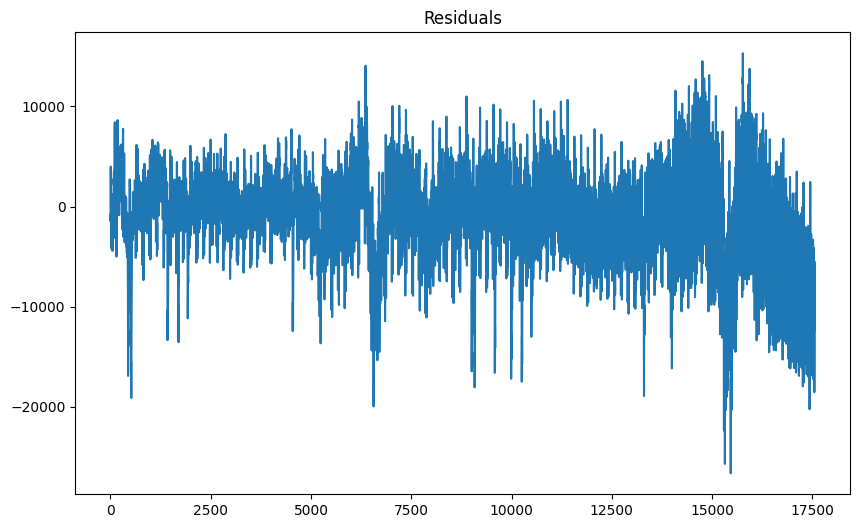

In [17]:
# Plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(df['residuals'])
plt.title('Residuals')
plt.show()

In [ ]:
# Save DataFrame to a CSV file
df.to_csv('load_22-24_model-neuralprophet.csv', index=False)

## Energy Peaks

In [11]:
# Get the peaks
peaks_df = df.groupby(df['ds'].dt.date)['y'].max().reset_index()
peaks_df['ds'] = pd.to_datetime(peaks_df['ds'])

In [13]:
# Split the dataframe in a train and test set

# Filter peaks_df for the years 2022 and 2023
peaks_df_train = peaks_df[(peaks_df['ds'].dt.year == 2022) | (peaks_df['ds'].dt.year == 2023)]
peaks_df_test = peaks_df[(peaks_df['ds'].dt.year == 2024)]

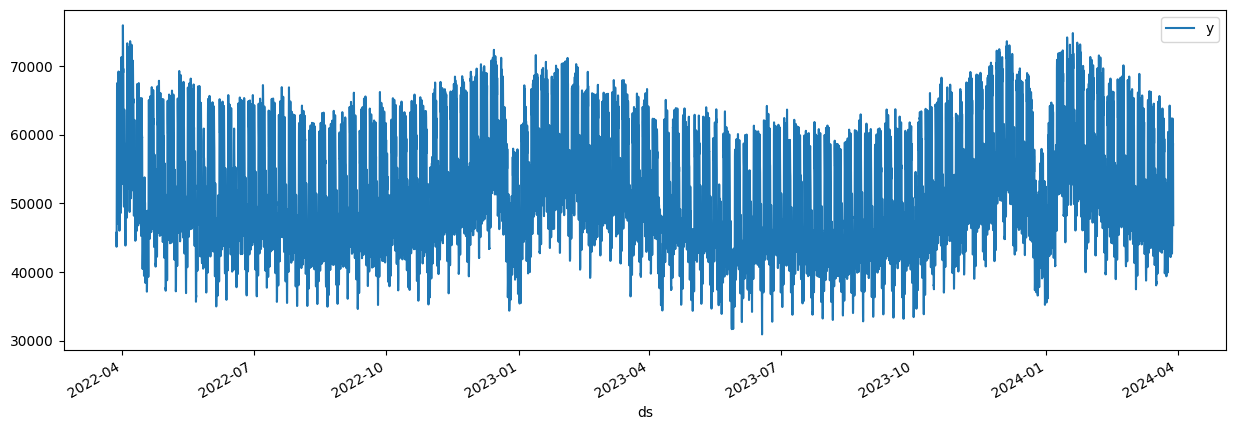

In [14]:
plt = df.plot(x="ds", y="y", figsize=(15, 5))

In [17]:
# Create a NeuralProphet model with default parameters
m = NeuralProphet()
# Use static plotly in notebooks
m.set_plotting_backend("plotly-resampler")

In [18]:
# Fit the model on the dataset (this might take a bit)
metrics = m.fit(peaks_df_train)

Finding best initial lr:   0%|          | 0/221 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [20]:
# Create a new dataframe reaching (NUMBER OF TEST) into the future for our forecast, n_historic_predictions also shows historic data
n = len(peaks_df_test)
df_future = m.make_future_dataframe(peaks_df_train, n_historic_predictions=True, periods=n)

# Predict the future
forecast_peaks = m.predict(df_future)

# Visualize the forecast
m.plot(forecast_peaks)

Predicting: 41it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '1e9e6b30-b1ba-49a6-bbdc-5a1e39d35a53',
              'x': array([datetime.datetime(2022, 3, 28, 0, 0),
                          datetime.datetime(2022, 3, 29, 0, 0),
                          datetime.datetime(2022, 3, 30, 0, 0), ...,
                          datetime.datetime(2024, 3, 26, 0, 0),
                          datetime.datetime(2024, 3, 27, 0, 0),
                          datetime.datetime(2024, 3, 28, 0, 0)], dtype=object),
              'y': array([68348.3359375, 69445.5546875, 69639.0703125, ..., 72931.34375  ,
                          73278.859375 , 73027.5546875])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
          

In [25]:
forecast_peaks.iloc[654:]

,ds,y,yhat1,trend,season_weekly
654,2024-01-11,NaN,69010.539062,65470.507812,3540.029053
655,2024-01-12,NaN,68438.468750,65522.675781,2915.791260
656,2024-01-13,NaN,59229.972656,65574.843750,-6344.874512
657,2024-01-14,NaN,55775.316406,65627.015625,-9851.698242
658,2024-01-15,NaN,68028.281250,65679.187500,2349.095215
...,...,...,...,...,...
727,2024-03-24,NaN,59427.152344,69278.851562,-9851.698242
728,2024-03-25,NaN,71680.117188,69331.015625,2349.095215
729,2024-03-26,NaN,72931.343750,69383.187500,3548.154053
730,2024-03-27,NaN,73278.859375,69435.359375,3843.502930


In [26]:
peaks_df_test.iloc[10:]

,ds,y
654,2024-01-11,71991.25
655,2024-01-12,72251.00
656,2024-01-13,64144.50
657,2024-01-14,61171.25
658,2024-01-15,74140.00
...,...,...
727,2024-03-24,51626.75
728,2024-03-25,60386.00
729,2024-03-26,64213.75
730,2024-03-27,62365.25


In [31]:
peaks_df_test.iloc[10:]['y'].values

array([71991.25, 72251.  , 64144.5 , 61171.25, 74140.  , 70982.75,
       73082.  , 71569.5 , 74770.  , 63606.  , 61545.25, 73381.75,
       72494.25, 73122.75, 69740.5 , 69989.75, 58438.75, 55016.  ,
       66610.75, 68755.25, 71291.75, 70875.  , 70086.  , 60136.5 ,
       59600.5 , 69643.75, 71517.25, 71232.  , 68904.  , 69638.75,
       56963.75, 55149.75, 65550.25, 67419.  , 68152.  , 66270.25,
       66222.75, 55900.25, 54884.25, 68046.25, 67726.25, 68279.5 ,
       68519.25, 70075.25, 56961.  , 54381.  , 67946.75, 68442.  ,
       65471.25, 66614.25, 65335.  , 52522.75, 51505.25, 66120.  ,
       68833.75, 65230.  , 65692.5 , 63796.25, 53463.  , 53406.25,
       65035.25, 66313.75, 66218.75, 63515.5 , 64498.5 , 55047.25,
       50497.75, 64774.75, 65603.75, 62809.5 , 63794.75, 62320.75,
       53548.5 , 51626.75, 60386.  , 64213.75, 62365.25, 62337.5 ])

In [32]:
forecast_peaks.iloc[654:]['y'] = peaks_df_test.iloc[10:]['y'].values

WARNING - (py.warnings._showwarnmsg) - /Users/Wohlfarth/Documents/Coding/uni/majwo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [34]:
peaks_df['yhat'] = forecast_peaks['yhat1']

In [35]:
# Visualize the forecast
m.plot(forecast_peaks)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '1565fc45-0c0c-4706-b892-4f4086e18336',
              'x': array([datetime.datetime(2022, 3, 28, 0, 0),
                          datetime.datetime(2022, 3, 29, 0, 0),
                          datetime.datetime(2022, 3, 30, 0, 0), ...,
                          datetime.datetime(2024, 3, 26, 0, 0),
                          datetime.datetime(2024, 3, 27, 0, 0),
                          datetime.datetime(2024, 3, 28, 0, 0)], dtype=object),
              'y': array([68348.3359375, 69445.5546875, 69639.0703125, ..., 72931.34375  ,
                          73278.859375 , 73027.5546875])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
          

In [36]:
# Calculate residuals
peaks_df['residuals'] = peaks_df['y'] - peaks_df['yhat']

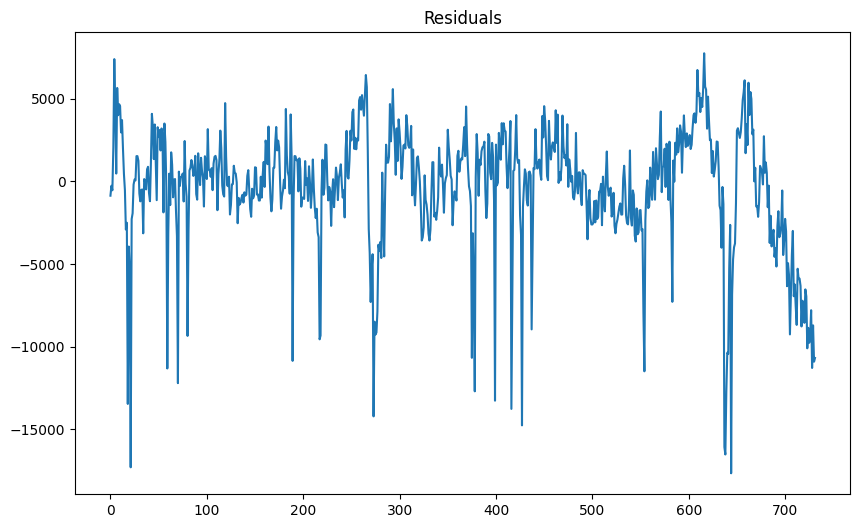

In [39]:
# Plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(peaks_df['residuals'])
plt.title('Residuals')
plt.show()

In [37]:
# Save DataFrame to a CSV file
peaks_df.to_csv('peaks_22-24_model-neuralprophet.csv', index=False)